### Import Modules

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import datetime
import calendar
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVR, SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from termcolor import colored, cprint
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

### Configuration


In [2]:
file = "cleaned_data.csv"
periods_to_drop: dict = {"covid": ["2020-02", "2021-04"],
                         #"gfc"  : ["2008-11", "2009-05"],
                        }

target: str = "italy_electricity_close_price_GMERTRB"

train_test_percentages: list = [0.9]
C_values: list = [0.01, 0.5, 1, 5, 10]
corr_threshold: float = 0.
epsilon = 0

### Read Data

In [3]:
def get_data(file: str,  periods_to_drop: dict, freq: str="M"):
    df = pd.read_csv(file, index_col=0)
    original_len = len(df)
    df = df.groupby(pd.PeriodIndex(df.index, freq=freq)).mean() # resample frequency
    df["consecutive_month"] = list(np.arange(1, len(df.index)+1, 1)) # add extra feature
    for k in periods_to_drop.values():
            df = df[(df.index < k[0]) + (df.index > k[1])]
    final_len = len(df)
    print("Resampled dataset (from {} to {} observations)".format(original_len, final_len))
    
    return df

In [4]:
data = get_data(file=file, periods_to_drop=periods_to_drop)

Resampled dataset (from 5930 to 181 observations)


### Describe Data

In [5]:
def color_negative_red(val):
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color

In [6]:
description_df = data.describe().T
description_df.style.applymap(color_negative_red).format('{:,.0f}')

,count,mean,std,min,25%,50%,75%,max
electricity_consumption_statista_eia_Gigawatt/h,181,304,8,291,297,302,312,318
fred_natgas_price_MHHNGSP,181,5,2,2,3,4,6,13
italy_gdpcap_VALUE,181,"34,686","2,891","29,807","32,024","34,606","36,431","40,817"
milano_weather_Avg. Temp.,181,14,8,-3,7,14,22,28
milano_weather_Avg. Wind,181,6,2,-0,5,6,7,13
torino_weather_Avg. Temp.,181,13,8,-0,6,13,20,26
torino_weather_Avg. Wind,181,7,1,3,6,7,8,10
italy_population_refinitiv_statista_Population,181,"59,530,207","967,577","57,963,468","58,751,095","59,417,040","60,534,803","60,817,621"
napoli_weather_Avg. Temp.,181,17,6,6,12,17,23,29
napoli_weather_Avg. Wind,181,8,2,2,7,9,10,14


### Autocorrelation

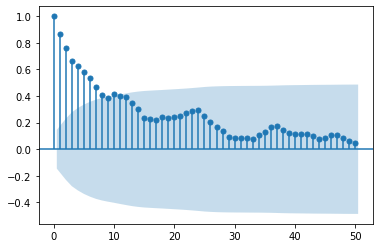

In [7]:
lag = 50
title = "Autocorrelation vs lags " + str(lag)
smt.graphics.plot_acf(data[target], lags=lag, alpha=0.05, title=None);

### Stationarity

In [8]:
def test_stationarity(df, alpha="5%"):
    """The function performs the Augmented Dickey-Fuller test in order to check stationarity of the timeseries data
       present in the input dataframe."""
    results = []
    for col in df.columns:
        print('\033[1m' + col + '\033[0m')
        data = df[col].values
        result = adfuller(data)
        print(f'\nADF Statistic: {result[0].round(4)}')
        print(f'p-value: {result[1].round(4)}')
        print('Critial Value: {}'.format(result[4][alpha].round(4)))
        if result[4][alpha] < list({result[0]})[0]:
            print(colored("\n--> Timeseries is non-stationary. The confidence interval is {}.".format(alpha), "red", attrs=['blink']))
            label = "Non-stationary"
        else:
            print(colored("\n--> Timeseries is stationary.The confidence interval is {}.".format(alpha), "green", attrs=['blink']))
            label = "Stationary"
        print("--------------------------------------------")
        results.append([col, result[0].round(4), result[1].round(4), result[4][alpha].round(4), label])
    df = pd.DataFrame(results, columns =["Variable name", "ADF Statistic", "P-Value", "Critical Value", "Label"])
    return df

In [9]:
ADF_table = test_stationarity(data)
ADF_table

electricity_consumption_statista_eia_Gigawatt/h

ADF Statistic: -0.9549
p-value: 0.7693
Critial Value: -2.8791

--> Timeseries is non-stationary. The confidence interval is 5%.
--------------------------------------------
fred_natgas_price_MHHNGSP

ADF Statistic: -1.37
p-value: 0.5965
Critial Value: -2.8791

--> Timeseries is non-stationary. The confidence interval is 5%.
--------------------------------------------
italy_gdpcap_VALUE

ADF Statistic: -1.2545
p-value: 0.6497
Critial Value: -2.8791

--> Timeseries is non-stationary. The confidence interval is 5%.
--------------------------------------------
milano_weather_Avg. Temp.

ADF Statistic: -2.8252
p-value: 0.0548
Critial Value: -2.8789

--> Timeseries is non-stationary. The confidence interval is 5%.
--------------------------------------------
milano_weather_Avg. Wind

ADF Statistic: -1.0755
p-value: 0.7247
Critial Value: -2.8788

--> Timeseries is non-stationary. The confidence interval is 5%.
---------------------------------

,Variable name,ADF Statistic,P-Value,Critical Value,Label
0,electricity_consumption_statista_eia_Gigawatt/h,-0.9549,0.7693,-2.8791,Non-stationary
1,fred_natgas_price_MHHNGSP,-1.3700,0.5965,-2.8791,Non-stationary
2,italy_gdpcap_VALUE,-1.2545,0.6497,-2.8791,Non-stationary
3,milano_weather_Avg. Temp.,-2.8252,0.0548,-2.8789,Non-stationary
4,milano_weather_Avg. Wind,-1.0755,0.7247,-2.8788,Non-stationary
5,torino_weather_Avg. Temp.,-1.9105,0.3271,-2.8789,Non-stationary
6,torino_weather_Avg. Wind,-2.9828,0.0365,-2.8791,Stationary
7,italy_population_refinitiv_statista_Population,-1.8258,0.3677,-2.8791,Non-stationary
8,napoli_weather_Avg. Temp.,-2.3921,0.1440,-2.8789,Non-stationary
9,napoli_weather_Avg. Wind,-3.3332,0.0135,-2.8779,Stationary


### Visualise Data

In [15]:
def get_plot(df, train_test_percentage: float):
    size=(20, 30)
    figure, axes = plt.subplots(figsize=size)
    count=1
    lister = df[[target] + [col for col in df.columns if col != target]] # sorted columns
    for i in lister:
        plt.subplot(11,2,count)
        if i == target:
            data[i].plot(title=i, fontsize=15, color="darkorange")
        else:
            data[i].plot(title=i, fontsize=15)
        plt.axvline(x=df.index[int(len(data)*train_test_percentage)], color="r")
        count+=1
    figure.tight_layout()
    plt.show()

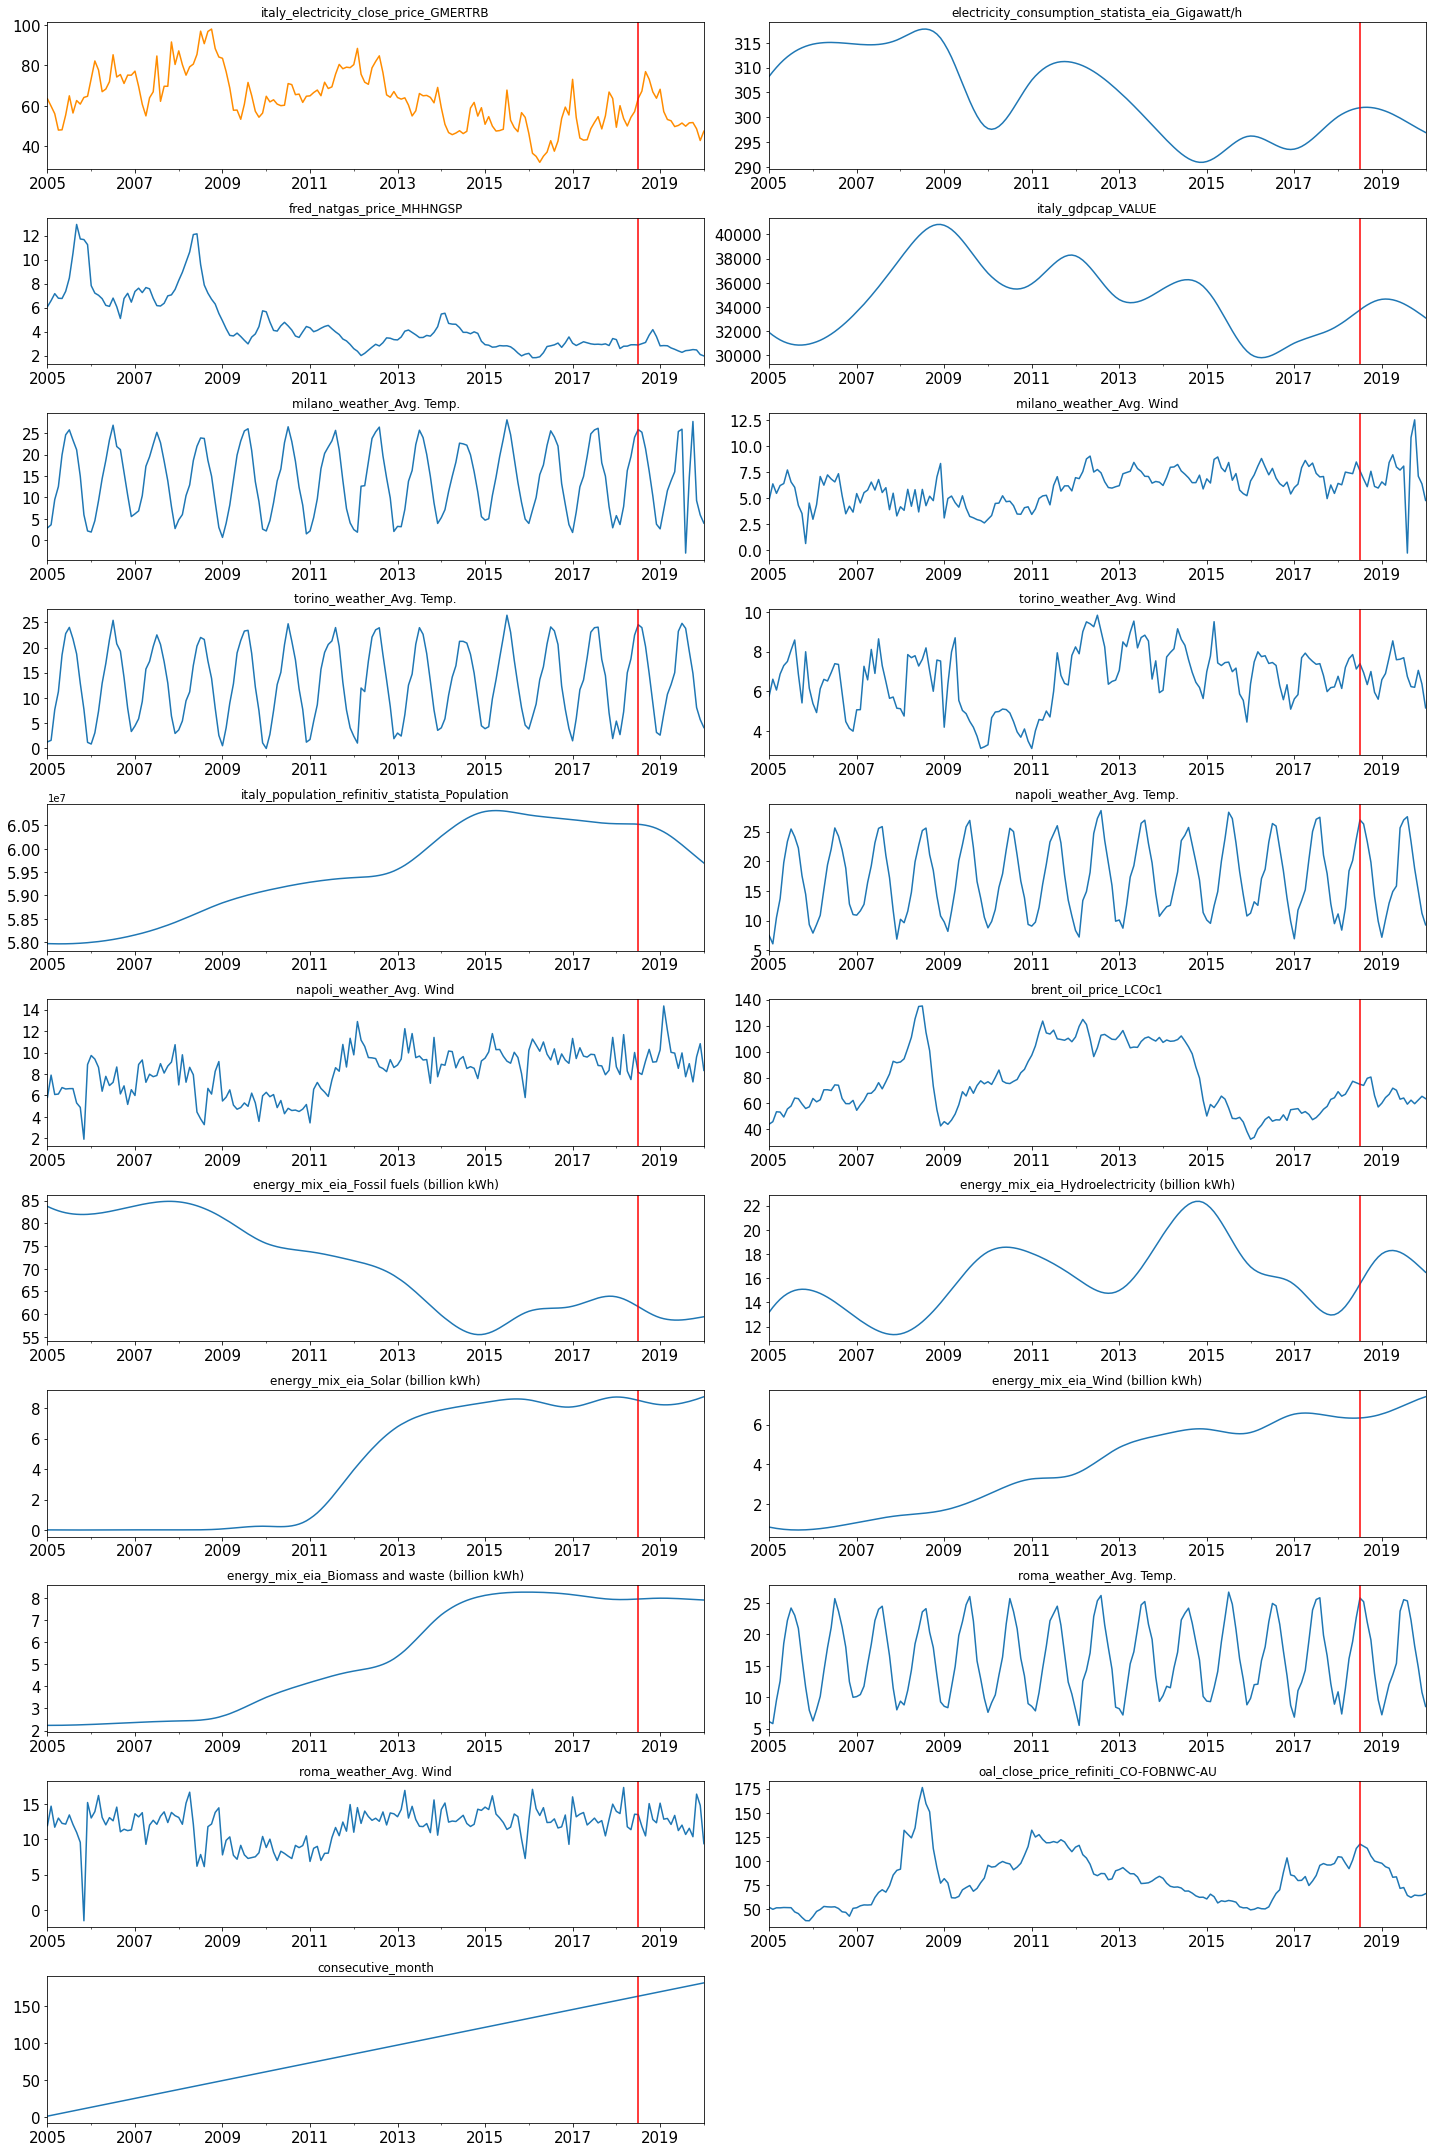

In [16]:
get_plot(data, train_test_percentage=train_test_percentages[0])

### Feature extraction

In [27]:
def get_features(df, train_test_percentage: float, corr_threshold: float, display=False):
    train_data = df.iloc[:int(len(df)*train_test_percentage)]
    corr_matrix = train_data.corr()
    if display:
        print(corr_matrix)
    arr = corr_matrix.loc[target][abs(corr_matrix.loc[target]) > corr_threshold].round(4)
    relevant_features = [i for i in arr.index]
    arr = arr.drop(target)
    relevant_features.remove(target)
    print(colored("Pearson's Correlation Matrix vs Target Variable ({}):\n".format(target), "blue", attrs=["blink"]))
    print(arr)
    
    return arr

In [30]:
relevant_features = get_features(df=data, train_test_percentage=train_test_percentages[0], 
                                 corr_threshold=corr_threshold, display=False)

Pearson's Correlation Matrix vs Target Variable (italy_electricity_close_price_GMERTRB):

electricity_consumption_statista_eia_Gigawatt/h    0.7399
fred_natgas_price_MHHNGSP                          0.4160
italy_gdpcap_VALUE                                 0.5863
milano_weather_Avg. Temp.                         -0.0843
milano_weather_Avg. Wind                          -0.3487
torino_weather_Avg. Temp.                         -0.0906
torino_weather_Avg. Wind                          -0.1028
italy_population_refinitiv_statista_Population    -0.5942
napoli_weather_Avg. Temp.                         -0.0571
napoli_weather_Avg. Wind                          -0.2492
brent_oil_price_LCOc1                              0.4371
energy_mix_eia_Fossil fuels (billion kWh)          0.6277
energy_mix_eia_Hydroelectricity (billion kWh)     -0.4243
energy_mix_eia_Solar (billion kWh)                -0.5821
energy_mix_eia_Wind (billion kWh)                 -0.5796
energy_mix_eia_Biomass and waste (billio

### Metric

In [31]:
# Most common metric
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    MSE = mean_squared_error(y_true, y_pred)
    RMSE = math.sqrt(MSE)
    return RMSE

### Process

In [35]:
def process(df, target: str, features: list, train_test_percentage: float):
    
    y = df[target].values
    X = df[features].values
    
    k = int(X.shape[0]*train_test_percentage)
    X_train, X_test = X[:k, :], X[k:, :]
    y_train, y_test = y[:k], y[k:]
    
    meanX_array = np.mean(X_train, axis=0).reshape(-1, 1)
    stdX_array = np.std(X_train, axis=0).reshape(-1, 1)
    meany_array = np.mean(y_train, axis=0).reshape(-1, 1)
    stdy_array = np.std(y_train, axis=0).reshape(-1, 1)
    
    normalisedXtrain_array = ((X_train.T - meanX_array) / stdX_array).T
    normalisedXtest_array = ((X_test.T - meanX_array) / stdX_array).T
    normalisedytrain_array = ((y_train.T - meany_array) / stdy_array).T
    normalisedytest_array = ((y_test.T - meany_array) / stdy_array).T
    
    print(f"{normalisedXtrain_array.shape=}, {normalisedXtest_array.shape=}, {normalisedytrain_array.shape=}, {normalisedytest_array.shape=}")
    
    return (normalisedXtrain_array, normalisedXtest_array, normalisedytrain_array, normalisedytest_array, meanX_array, stdX_array, meany_array, stdy_array)

### Train Mean model (baseline), use the mean on train to predict the values of test

normalisedXtrain_array.shape=(162, 1), normalisedXtest_array.shape=(19, 1), normalisedytrain_array.shape=(162, 1), normalisedytest_array.shape=(19, 1)
Train R²: 0.2956
Test R²: -0.5239
Train MAPE: 100.0
Test MAPE: 100.0
Train RMSE: 1.0
Test RMSE: 0.849


Text(0.5, 0, 'consecutive_month')

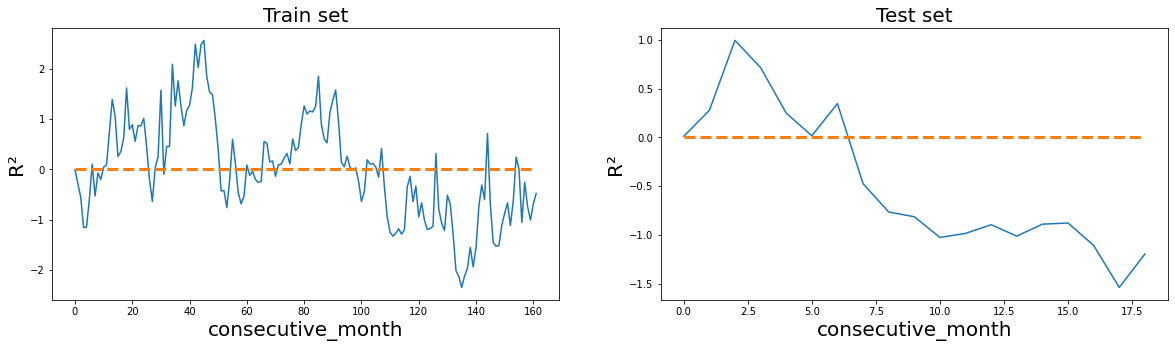

In [36]:
xs_train, xs_test, ys_train, ys_test, meanX_array, stdX_array, meany_array, stdy_array = process(data, target=target, features=["consecutive_month"], train_test_percentage=train_test_percentages[0])

k = int(len(data)*train_test_percentages[0])
tr_preds = np.ones(k)*np.mean(ys_train)
te_preds = np.ones(len(data) - k)*np.mean(ys_train)

print("Train R\u00b2:", ln_model.score(xs_train, ys_train).round(4))
print("Test R\u00b2:", ln_model.score(xs_test, ys_test).round(4))
print("Train MAPE:", mean_absolute_percentage_error(ys_train, tr_preds).round(2))
print("Test MAPE:", mean_absolute_percentage_error(ys_test, te_preds).round(2))
print("Train RMSE:", round(root_mean_squared_error(ys_train, tr_preds), 4))
print("Test RMSE:", round(root_mean_squared_error(ys_test, te_preds), 4))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
ax1.plot(range(len(ys_train)), ys_train)
ax1.plot(range(len(ys_train)), tr_preds, "--", linewidth=3.0)
ax1.set_title("Train set", fontsize=20)
ax1.set_ylabel("R\u00b2", fontsize=20)
ax1.set_xlabel("consecutive_month", fontsize=20)

ax2.plot(range(len(ys_test)), ys_test)
ax2.plot(range(len(ys_test)), te_preds, "--", linewidth=3.0)
ax2.set_title("Test set", fontsize=20)
ax2.set_ylabel("R\u00b2", fontsize=20)
ax2.set_xlabel("consecutive_month", fontsize=20)


### Linear Regression (new baseline, univariate)

normalisedXtrain_array.shape=(162, 1), normalisedXtest_array.shape=(19, 1), normalisedytrain_array.shape=(162, 1), normalisedytest_array.shape=(19, 1)
Train R²: 0.2956
Test R²: -0.5239
Train MAPE: 346.1
Test MAPE: 966.84
Train RMSE: 0.8393
Test RMSE: 0.8702


Text(0.5, 0, 'consecutive_month')

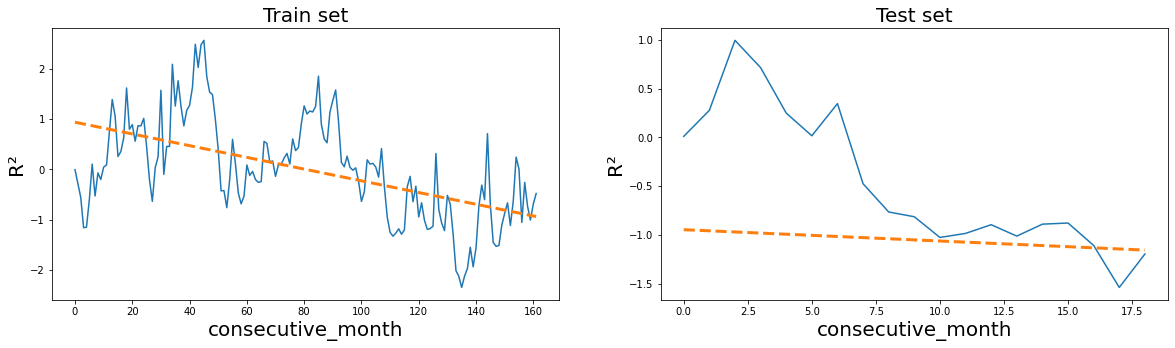

In [37]:
xs_train, xs_test, ys_train, ys_test,  meanX_array, stdX_array, meany_array, stdy_array = process(data, target=target, features=["consecutive_month"], train_test_percentage=train_test_percentages[0])

ln_model = LinearRegression().fit(xs_train, ys_train)
tr_preds = ln_model.predict(xs_train)
te_preds = ln_model.predict(xs_test)

print("Train R\u00b2:", ln_model.score(xs_train, ys_train).round(4))
print("Test R\u00b2:", ln_model.score(xs_test, ys_test).round(4))
print("Train MAPE:", mean_absolute_percentage_error(ys_train, tr_preds).round(2))
print("Test MAPE:", mean_absolute_percentage_error(ys_test, te_preds).round(2))
print("Train RMSE:", round(root_mean_squared_error(ys_train, tr_preds), 4))
print("Test RMSE:", round(root_mean_squared_error(ys_test, te_preds), 4))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
ax1.plot(range(len(ys_train)), ys_train)
ax1.plot(range(len(ys_train)), tr_preds, "--", linewidth=3.0)
ax1.set_title("Train set", fontsize=20)
ax1.set_ylabel("R\u00b2", fontsize=20)
ax1.set_xlabel("consecutive_month", fontsize=20)

ax2.plot(range(len(ys_test)), ys_test)
ax2.plot(range(len(ys_test)), te_preds, "--", linewidth=3.0)
ax2.set_title("Test set", fontsize=20)
ax2.set_ylabel("R\u00b2", fontsize=20)
ax2.set_xlabel("consecutive_month", fontsize=20)

### SVR configuration

In [38]:
sets_to_test = {"set1" : ["energy_mix_eia_Fossil fuels (billion kWh)", "energy_mix_eia_Solar (billion kWh)",
                          "energy_mix_eia_Hydroelectricity (billion kWh)", "energy_mix_eia_Wind (billion kWh)", 
                          "energy_mix_eia_Biomass and waste (billion kWh)"],
                "set2" : ["italy_gdpcap_VALUE", "italy_population_refinitiv_statista_Population"], 
                "set3" : [i for i in data.columns if i != target], 
                "set4" : ["fred_natgas_price_MHHNGSP", "brent_oil_price_LCOc1", "oal_close_price_refiniti_CO-FOBNWC-AU"], 
                "set5" : ["electricity_consumption_statista_eia_Gigawatt/h", 
                          "oal_close_price_refiniti_CO-FOBNWC-AU", "energy_mix_eia_Fossil fuels (billion kWh)", 
                          "energy_mix_eia_Solar (billion kWh)", "energy_mix_eia_Hydroelectricity (billion kWh)", 
                          "energy_mix_eia_Wind (billion kWh)", "energy_mix_eia_Biomass and waste (billion kWh)"]
               }

### Model selection

In [58]:
def get_model_performance(X_train, X_test, y_train, y_test, C, epsilon):
    
    # Use best model
    model0 = LinearSVR(C=C, epsilon=epsilon, max_iter=100000)
    model0.fit(X_train, y_train)
    train_preds = model0.predict(X_train)
    test_preds = model0.predict(X_test)
    
    train_r2 = model0.score(X_train, y_train).round(4)
    test_r2 = model0.score(X_test, y_test).round(4)
    train_mape = mean_absolute_percentage_error(y_train, train_preds).round(2)
    test_mape = mean_absolute_percentage_error(y_test, test_preds).round(2)
    train_rmse = round(root_mean_squared_error(y_train, train_preds), 4)
    test_rmse = round(root_mean_squared_error(y_test, test_preds), 4)
    
    print("Train R\u00b2:", train_r2)
    print("Test R\u00b2:", test_r2)
    print("Train MAPE:", train_mape)
    print("Test MAPE:", test_mape)
    print("Train RMSE:", train_rmse)
    print("Test RMSE:", test_rmse)
    
    # Plot predictions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
    ax1.plot(range(len(y_train)), y_train)
    ax1.plot(range(len(y_train)), train_preds)
    ax1.set_title("Train set", fontsize=20)
    ax2.plot(range(len(y_test)), y_test)
    ax2.plot(range(len(y_test)), test_preds)
    ax2.set_title("Test set", fontsize=20)

    plt.show()
    
    return train_r2, test_r2, train_mape, test_mape, train_rmse, test_rmse

______________________________________________________________________________________________________________

Results for set1

train_test_percentage: 0.9
normalisedXtrain_array.shape=(162, 5), normalisedXtest_array.shape=(19, 5), normalisedytrain_array.shape=(162, 1), normalisedytest_array.shape=(19, 1)

C: 0.01
Epsilon: 0
Train R²: 0.4
Test R²: -0.0402
Train MAPE: 336.25
Test MAPE: 733.45
Train RMSE: 0.7746
Test RMSE: 0.7189


/Users/macbookpro/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


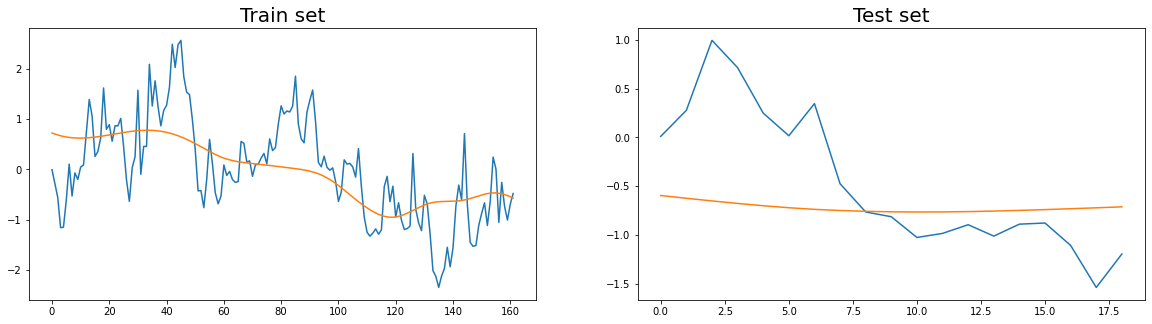

Results for set1

train_test_percentage: 0.9
normalisedXtrain_array.shape=(162, 5), normalisedXtest_array.shape=(19, 5), normalisedytrain_array.shape=(162, 1), normalisedytest_array.shape=(19, 1)

C: 0.5
Epsilon: 0
Train R²: 0.4621
Test R²: -0.2798
Train MAPE: 370.89
Test MAPE: 732.57
Train RMSE: 0.7334
Test RMSE: 0.7974


/Users/macbookpro/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


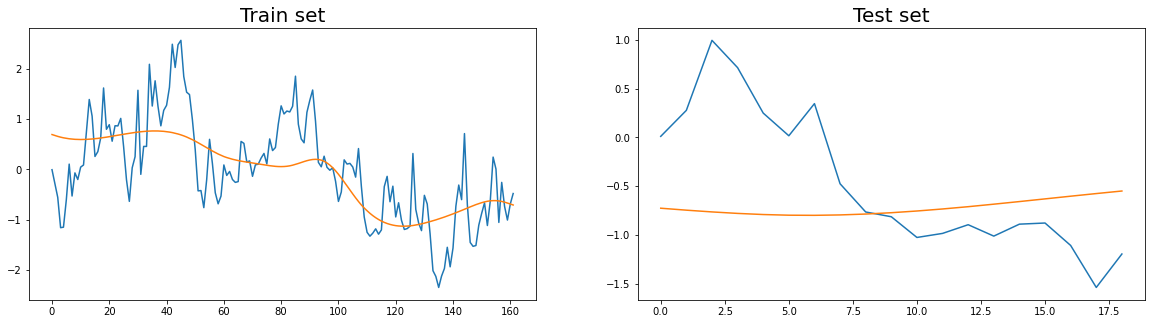

Results for set1

train_test_percentage: 0.9
normalisedXtrain_array.shape=(162, 5), normalisedXtest_array.shape=(19, 5), normalisedytrain_array.shape=(162, 1), normalisedytest_array.shape=(19, 1)

C: 1
Epsilon: 0
Train R²: 0.4724
Test R²: -0.2994
Train MAPE: 373.35
Test MAPE: 700.58
Train RMSE: 0.7264
Test RMSE: 0.8035


/Users/macbookpro/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


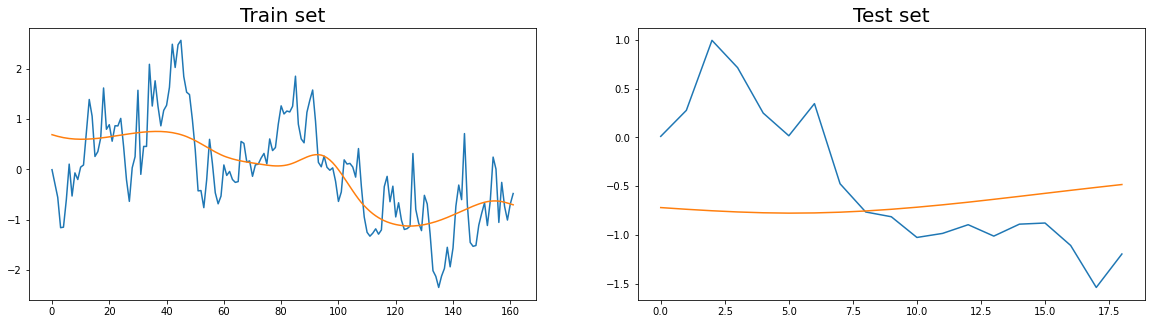

Results for set1

train_test_percentage: 0.9
normalisedXtrain_array.shape=(162, 5), normalisedXtest_array.shape=(19, 5), normalisedytrain_array.shape=(162, 1), normalisedytest_array.shape=(19, 1)

C: 5
Epsilon: 0
Train R²: 0.4906
Test R²: -0.463
Train MAPE: 393.42
Test MAPE: 555.24
Train RMSE: 0.7137
Test RMSE: 0.8526


/Users/macbookpro/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


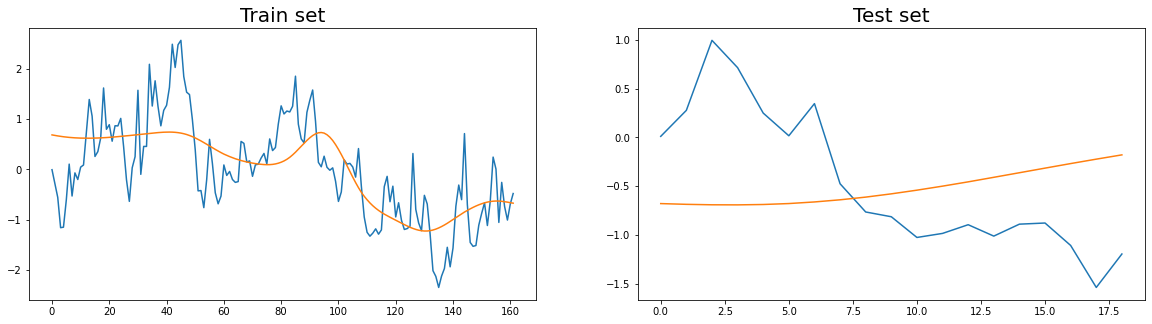

Results for set1

train_test_percentage: 0.9
normalisedXtrain_array.shape=(162, 5), normalisedXtest_array.shape=(19, 5), normalisedytrain_array.shape=(162, 1), normalisedytest_array.shape=(19, 1)

C: 10
Epsilon: 0
Train R²: 0.4905
Test R²: -0.463
Train MAPE: 391.38
Test MAPE: 548.21
Train RMSE: 0.7138
Test RMSE: 0.8526


/Users/macbookpro/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


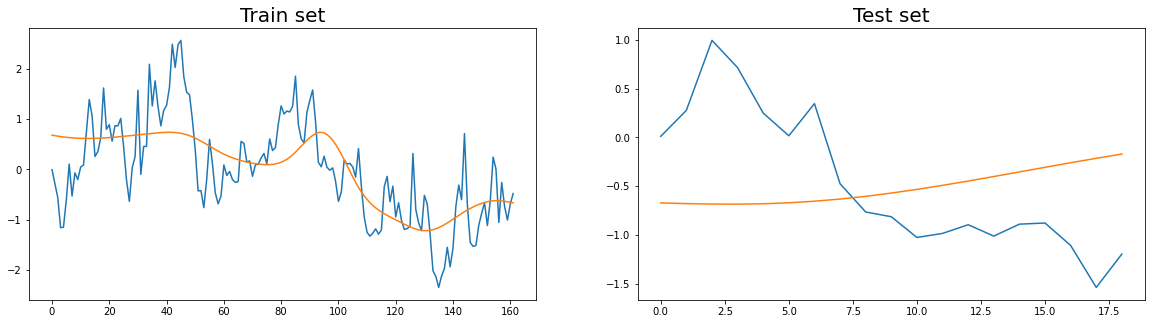

______________________________________________________________________________________________________________

Results for set2

train_test_percentage: 0.9
normalisedXtrain_array.shape=(162, 2), normalisedXtest_array.shape=(19, 2), normalisedytrain_array.shape=(162, 1), normalisedytest_array.shape=(19, 1)

C: 0.01
Epsilon: 0
Train R²: 0.5103
Test R²: -0.2298
Train MAPE: 297.01
Test MAPE: 364.26
Train RMSE: 0.6998
Test RMSE: 0.7817


/Users/macbookpro/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


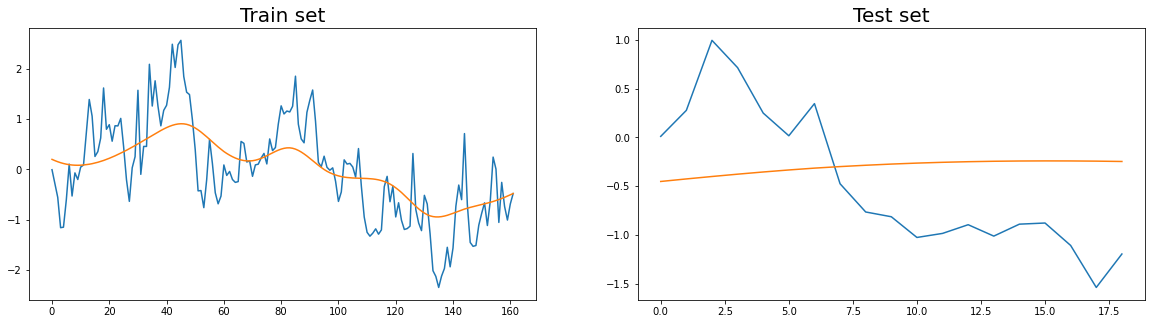

Results for set2

train_test_percentage: 0.9
normalisedXtrain_array.shape=(162, 2), normalisedXtest_array.shape=(19, 2), normalisedytrain_array.shape=(162, 1), normalisedytest_array.shape=(19, 1)

C: 0.5
Epsilon: 0
Train R²: 0.559
Test R²: -0.2599
Train MAPE: 422.05
Test MAPE: 508.99
Train RMSE: 0.6641
Test RMSE: 0.7912


/Users/macbookpro/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


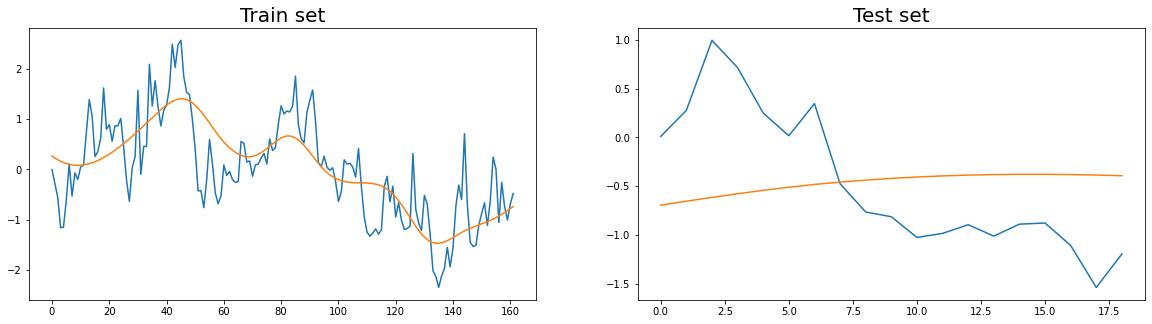

Results for set2

train_test_percentage: 0.9
normalisedXtrain_array.shape=(162, 2), normalisedXtest_array.shape=(19, 2), normalisedytrain_array.shape=(162, 1), normalisedytest_array.shape=(19, 1)

C: 1
Epsilon: 0
Train R²: 0.5589
Test R²: -0.2601
Train MAPE: 422.27
Test MAPE: 509.27
Train RMSE: 0.6641
Test RMSE: 0.7913


/Users/macbookpro/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


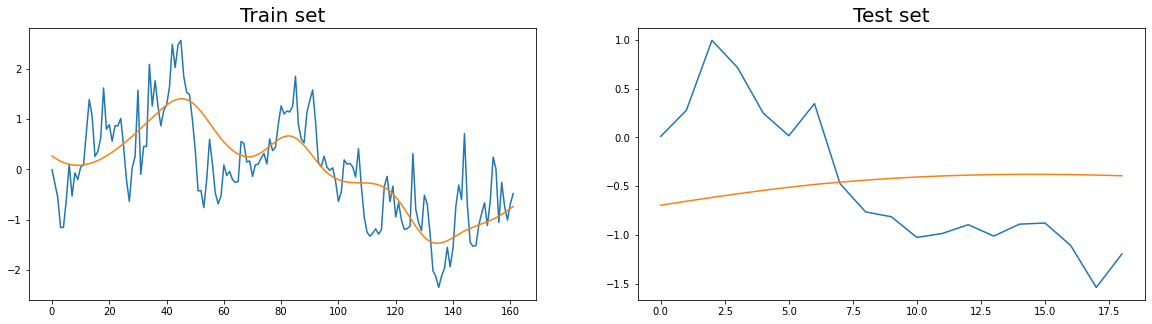

Results for set2

train_test_percentage: 0.9
normalisedXtrain_array.shape=(162, 2), normalisedXtest_array.shape=(19, 2), normalisedytrain_array.shape=(162, 1), normalisedytest_array.shape=(19, 1)

C: 5
Epsilon: 0
Train R²: 0.559
Test R²: -0.2594
Train MAPE: 421.7
Test MAPE: 508.5
Train RMSE: 0.664
Test RMSE: 0.7911


/Users/macbookpro/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


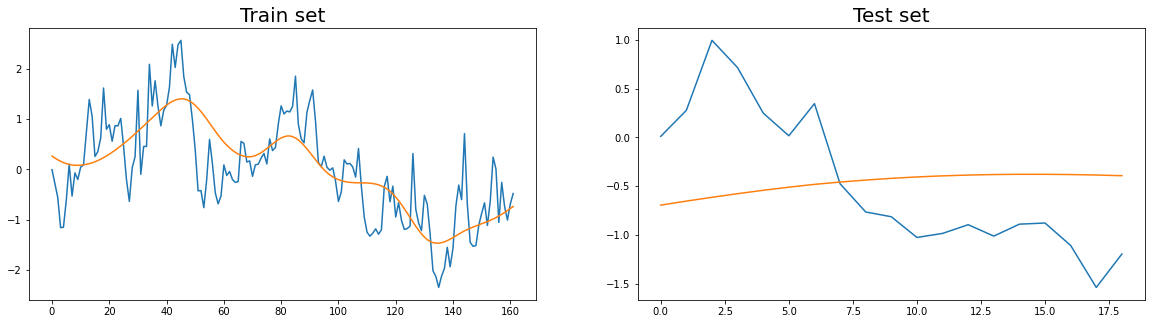

Results for set2

train_test_percentage: 0.9
normalisedXtrain_array.shape=(162, 2), normalisedXtest_array.shape=(19, 2), normalisedytrain_array.shape=(162, 1), normalisedytest_array.shape=(19, 1)

C: 10
Epsilon: 0
Train R²: 0.5589
Test R²: -0.2598
Train MAPE: 422.42
Test MAPE: 509.38
Train RMSE: 0.6642
Test RMSE: 0.7912


/Users/macbookpro/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


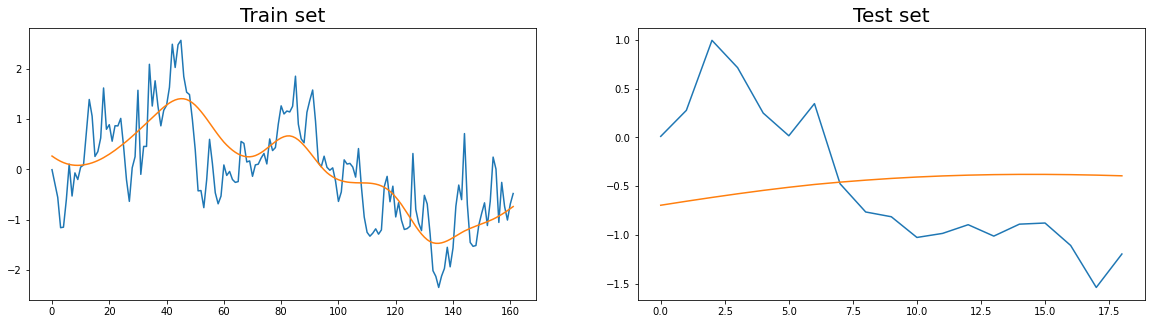

______________________________________________________________________________________________________________

Results for set3

train_test_percentage: 0.9
normalisedXtrain_array.shape=(162, 20), normalisedXtest_array.shape=(19, 20), normalisedytrain_array.shape=(162, 1), normalisedytest_array.shape=(19, 1)

C: 0.01
Epsilon: 0
Train R²: 0.6711
Test R²: 0.2725
Train MAPE: 367.12
Test MAPE: 633.12
Train RMSE: 0.5735
Test RMSE: 0.6012


/Users/macbookpro/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


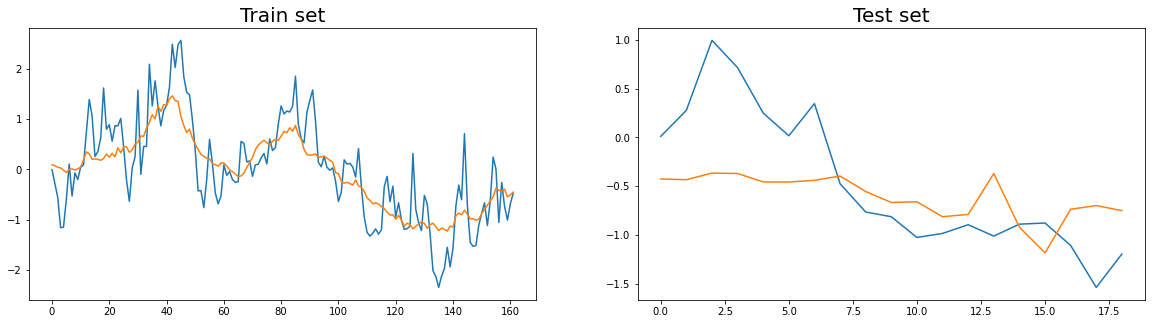

Results for set3

train_test_percentage: 0.9
normalisedXtrain_array.shape=(162, 20), normalisedXtest_array.shape=(19, 20), normalisedytrain_array.shape=(162, 1), normalisedytest_array.shape=(19, 1)

C: 0.5
Epsilon: 0
Train R²: 0.7566
Test R²: 0.5151
Train MAPE: 424.54
Test MAPE: 564.67
Train RMSE: 0.4933
Test RMSE: 0.4908


/Users/macbookpro/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


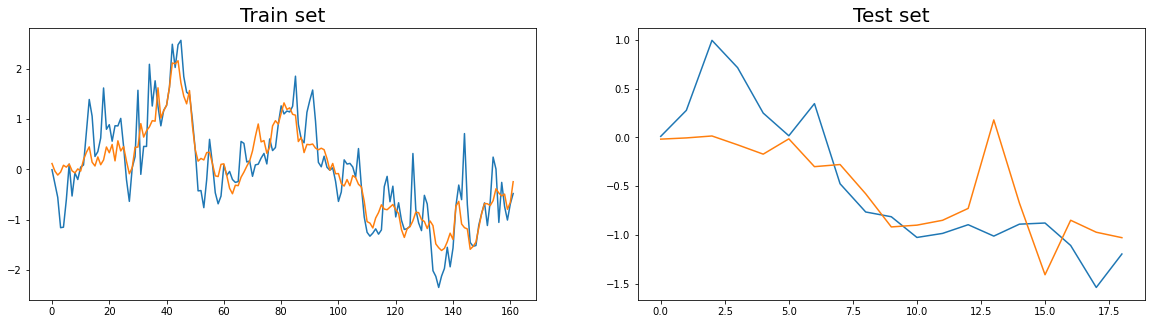

Results for set3

train_test_percentage: 0.9
normalisedXtrain_array.shape=(162, 20), normalisedXtest_array.shape=(19, 20), normalisedytrain_array.shape=(162, 1), normalisedytest_array.shape=(19, 1)

C: 1
Epsilon: 0
Train R²: 0.7595
Test R²: 0.6422
Train MAPE: 439.45
Test MAPE: 498.98
Train RMSE: 0.4904
Test RMSE: 0.4216


/Users/macbookpro/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


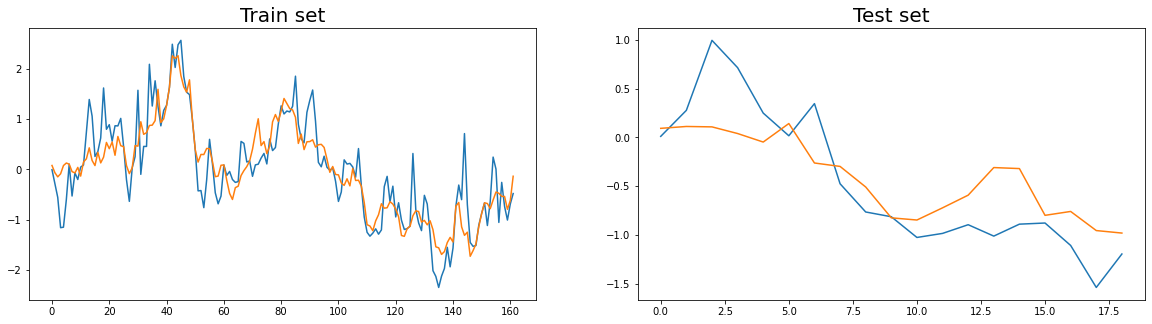

Results for set3

train_test_percentage: 0.9
normalisedXtrain_array.shape=(162, 20), normalisedXtest_array.shape=(19, 20), normalisedytrain_array.shape=(162, 1), normalisedytest_array.shape=(19, 1)

C: 5
Epsilon: 0
Train R²: 0.7582
Test R²: 0.4367
Train MAPE: 439.46
Test MAPE: 377.98
Train RMSE: 0.4918
Test RMSE: 0.5291


/Users/macbookpro/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


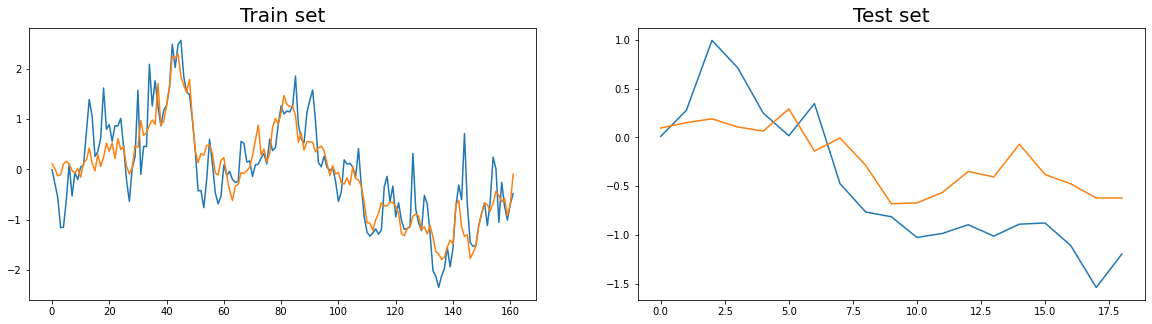

Results for set3

train_test_percentage: 0.9
normalisedXtrain_array.shape=(162, 20), normalisedXtest_array.shape=(19, 20), normalisedytrain_array.shape=(162, 1), normalisedytest_array.shape=(19, 1)

C: 10
Epsilon: 0
Train R²: 0.7566
Test R²: 0.4744
Train MAPE: 445.21
Test MAPE: 398.14
Train RMSE: 0.4933
Test RMSE: 0.5111


/Users/macbookpro/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


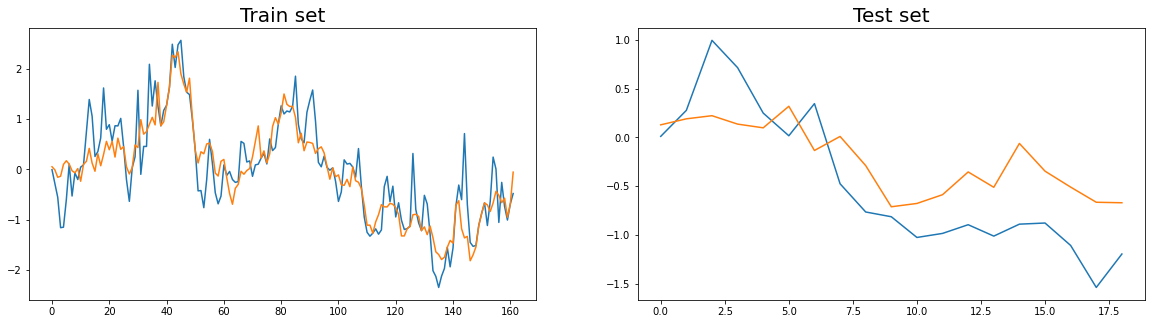

______________________________________________________________________________________________________________

Results for set4

train_test_percentage: 0.9
normalisedXtrain_array.shape=(162, 3), normalisedXtest_array.shape=(19, 3), normalisedytrain_array.shape=(162, 1), normalisedytest_array.shape=(19, 1)

C: 0.01
Epsilon: 0
Train R²: 0.337
Test R²: 0.3584
Train MAPE: 236.44
Test MAPE: 384.05
Train RMSE: 0.8143
Test RMSE: 0.5646


/Users/macbookpro/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


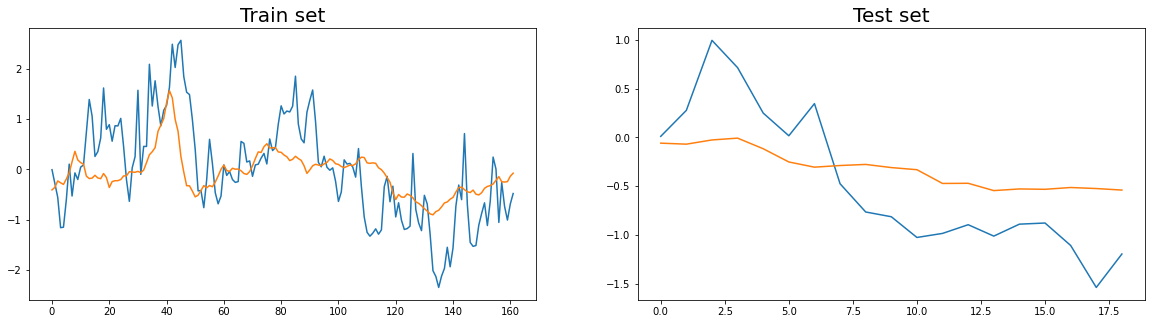

Results for set4

train_test_percentage: 0.9
normalisedXtrain_array.shape=(162, 3), normalisedXtest_array.shape=(19, 3), normalisedytrain_array.shape=(162, 1), normalisedytest_array.shape=(19, 1)

C: 0.5
Epsilon: 0
Train R²: 0.3691
Test R²: 0.5317
Train MAPE: 323.62
Test MAPE: 568.51
Train RMSE: 0.7943
Test RMSE: 0.4824


/Users/macbookpro/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


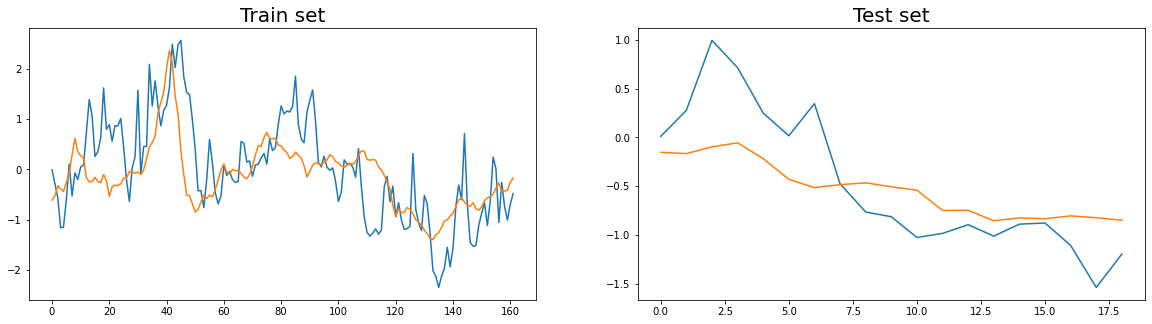

Results for set4

train_test_percentage: 0.9
normalisedXtrain_array.shape=(162, 3), normalisedXtest_array.shape=(19, 3), normalisedytrain_array.shape=(162, 1), normalisedytest_array.shape=(19, 1)

C: 1
Epsilon: 0
Train R²: 0.3691
Test R²: 0.5319
Train MAPE: 323.66
Test MAPE: 568.54
Train RMSE: 0.7943
Test RMSE: 0.4823


/Users/macbookpro/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


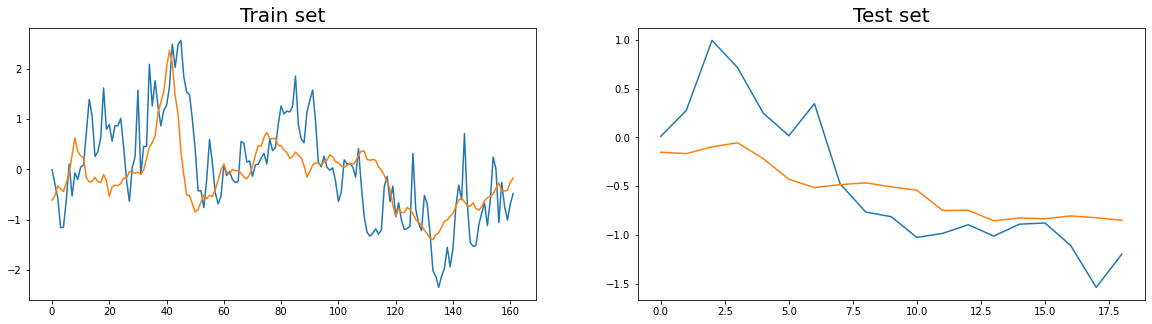

Results for set4

train_test_percentage: 0.9
normalisedXtrain_array.shape=(162, 3), normalisedXtest_array.shape=(19, 3), normalisedytrain_array.shape=(162, 1), normalisedytest_array.shape=(19, 1)

C: 5
Epsilon: 0
Train R²: 0.3698
Test R²: 0.5408
Train MAPE: 326.08
Test MAPE: 575.77
Train RMSE: 0.7938
Test RMSE: 0.4777


/Users/macbookpro/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


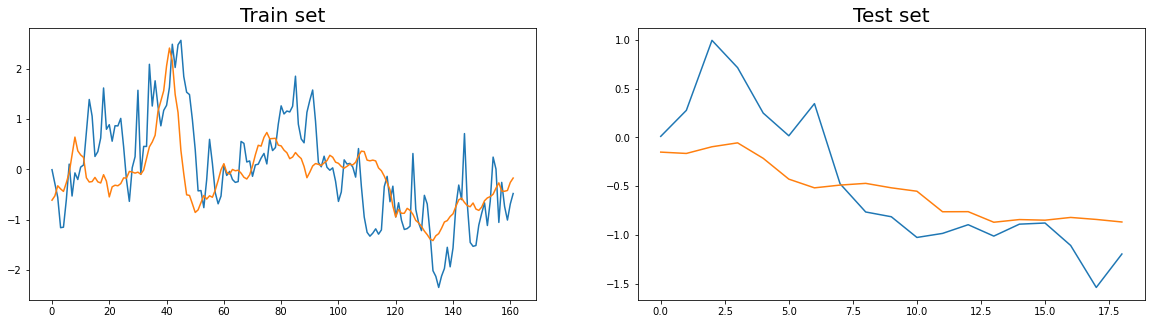

Results for set4

train_test_percentage: 0.9
normalisedXtrain_array.shape=(162, 3), normalisedXtest_array.shape=(19, 3), normalisedytrain_array.shape=(162, 1), normalisedytest_array.shape=(19, 1)

C: 10
Epsilon: 0
Train R²: 0.3704
Test R²: 0.5418
Train MAPE: 324.85
Test MAPE: 573.65
Train RMSE: 0.7935
Test RMSE: 0.4772


/Users/macbookpro/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


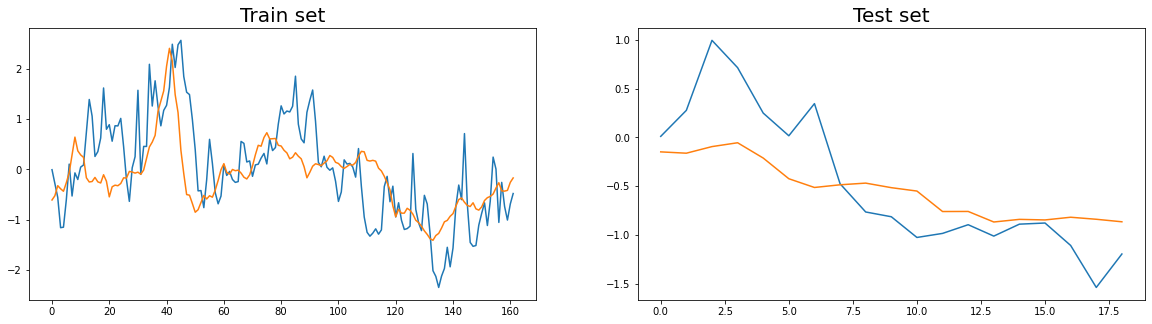

______________________________________________________________________________________________________________

Results for set5

train_test_percentage: 0.9
normalisedXtrain_array.shape=(162, 7), normalisedXtest_array.shape=(19, 7), normalisedytrain_array.shape=(162, 1), normalisedytest_array.shape=(19, 1)

C: 0.01
Epsilon: 0
Train R²: 0.6068
Test R²: 0.4813
Train MAPE: 359.21
Test MAPE: 591.13
Train RMSE: 0.6271
Test RMSE: 0.5077


/Users/macbookpro/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


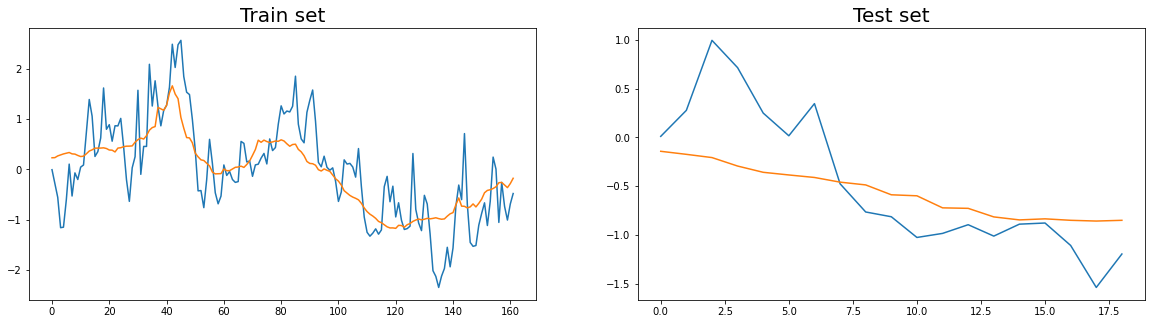

Results for set5

train_test_percentage: 0.9
normalisedXtrain_array.shape=(162, 7), normalisedXtest_array.shape=(19, 7), normalisedytrain_array.shape=(162, 1), normalisedytest_array.shape=(19, 1)

C: 0.5
Epsilon: 0
Train R²: 0.6773
Test R²: 0.6823
Train MAPE: 408.67
Test MAPE: 571.67
Train RMSE: 0.5681
Test RMSE: 0.3973


/Users/macbookpro/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


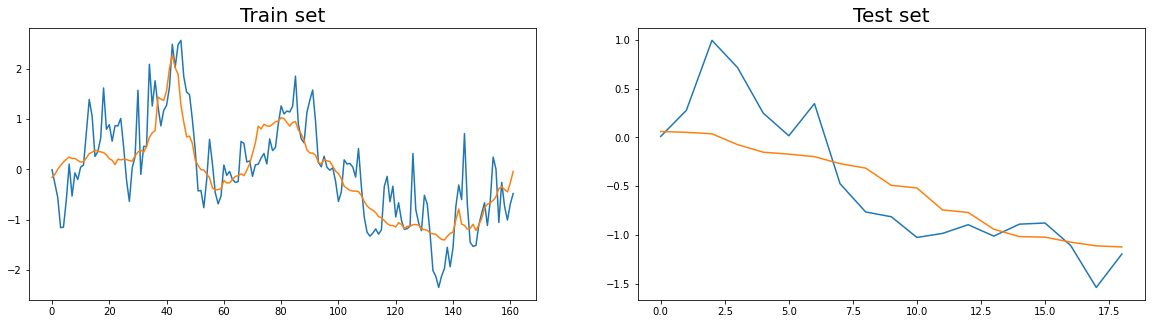

Results for set5

train_test_percentage: 0.9
normalisedXtrain_array.shape=(162, 7), normalisedXtest_array.shape=(19, 7), normalisedytrain_array.shape=(162, 1), normalisedytest_array.shape=(19, 1)

C: 1
Epsilon: 0
Train R²: 0.6798
Test R²: 0.6721
Train MAPE: 407.74
Test MAPE: 615.5
Train RMSE: 0.5659
Test RMSE: 0.4036


/Users/macbookpro/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


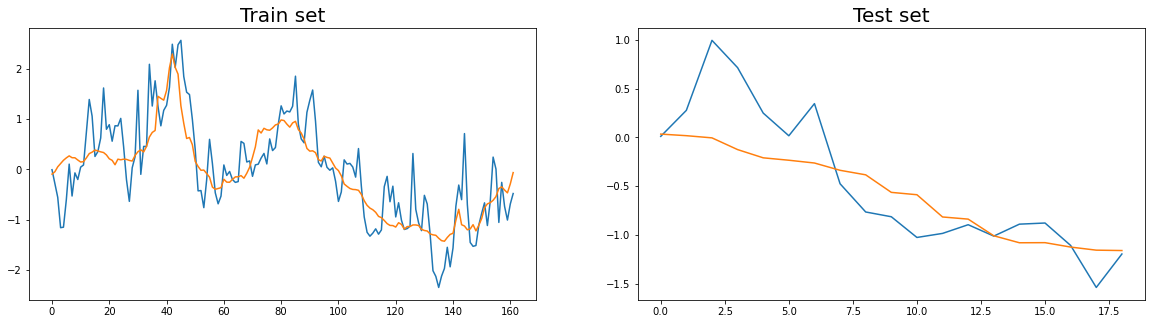

Results for set5

train_test_percentage: 0.9
normalisedXtrain_array.shape=(162, 7), normalisedXtest_array.shape=(19, 7), normalisedytrain_array.shape=(162, 1), normalisedytest_array.shape=(19, 1)

C: 5
Epsilon: 0
Train R²: 0.6799
Test R²: 0.6676
Train MAPE: 419.12
Test MAPE: 641.61
Train RMSE: 0.5657
Test RMSE: 0.4064


/Users/macbookpro/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


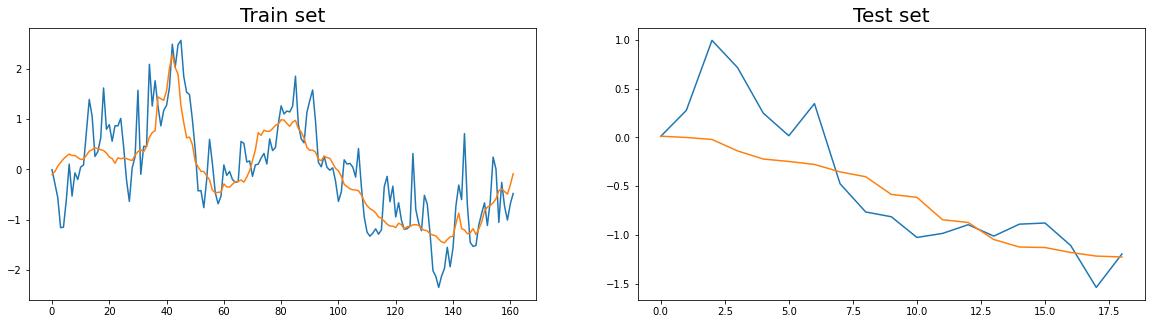

Results for set5

train_test_percentage: 0.9
normalisedXtrain_array.shape=(162, 7), normalisedXtest_array.shape=(19, 7), normalisedytrain_array.shape=(162, 1), normalisedytest_array.shape=(19, 1)

C: 10
Epsilon: 0
Train R²: 0.6799
Test R²: 0.6643
Train MAPE: 419.96
Test MAPE: 650.32
Train RMSE: 0.5658
Test RMSE: 0.4084


/Users/macbookpro/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


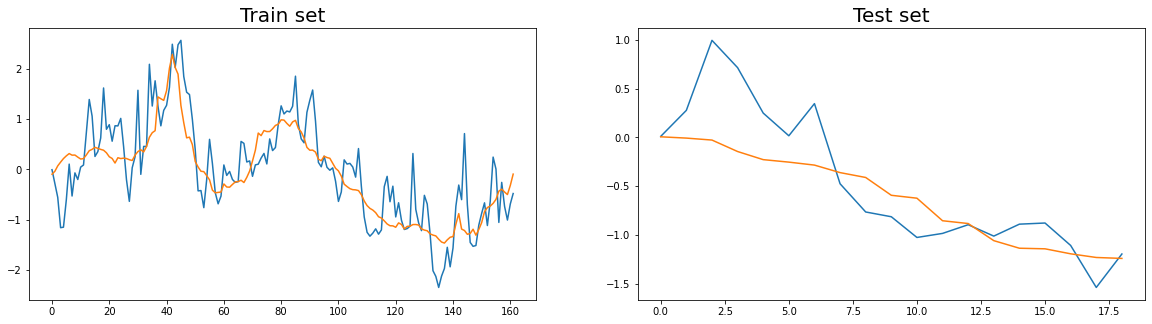

In [59]:
results = []
for key, value in sets_to_test.items():
    print("______________________________________________________________________________________________________________\n")
    for C in C_values:
        for ttp in train_test_percentages:
            print(colored("Results for {}\n".format(key), "blue", attrs=["blink"]))
            print("train_test_percentage: {}".format(ttp))
            X_train, X_test, y_train, y_test, meanX_array, stdX_array, meany_array, stdy_array = process(data, target=target, features=value,
                                                       train_test_percentage=ttp)
            print()
            print("C: {}".format(C))
            print("Epsilon: {}".format(epsilon))
            train_r2, test_r2, train_mape, test_mape, train_rmse, test_rmse = get_model_performance(X_train, X_test, y_train, y_test, C, epsilon)
            results.append((key, C, epsilon, ttp, train_r2, test_r2, train_mape, test_mape, train_rmse, test_rmse))
df = pd.DataFrame(results, columns =["Set Name", "C", "Epsilon", "TTS perc.", "Train R\u00b2", "Test R\u00b2", "Train MAPE", "Test MAPE", "Train RMSE", "Test RMSE"])

In [41]:
df.sort_values(by=["Test R\u00b2"], ascending=False)

,Set Name,C,Epsilon,TTS perc.,Train R²,Test R²,Train MAPE,Test MAPE,Train RMSE,Test RMSE
21,set5,0.50,0,0.9,0.6775,0.6824,409.66,573.29,0.5679,0.3973
22,set5,1.00,0,0.9,0.6795,0.6738,405.83,610.76,0.5661,0.4026
23,set5,5.00,0,0.9,0.6800,0.6668,419.35,643.45,0.5657,0.4069
24,set5,10.00,0,0.9,0.6801,0.6653,420.68,645.75,0.5656,0.4078
12,set3,1.00,0,0.9,0.7594,0.6377,439.53,497.50,0.4905,0.4243
18,set4,5.00,0,0.9,0.3702,0.5402,324.60,572.91,0.7936,0.4780
19,set4,10.00,0,0.9,0.3698,0.5376,324.15,571.33,0.7938,0.4793
16,set4,0.50,0,0.9,0.3692,0.5321,323.72,568.49,0.7942,0.4822
17,set4,1.00,0,0.9,0.3691,0.5319,323.72,568.62,0.7943,0.4823
11,set3,0.50,0,0.9,0.7568,0.5063,424.38,566.88,0.4931,0.4953


In [42]:
x = np.array(df["C"])
y = np.array(df["TTS perc."])
z = np.array(df["Test R\u00b2"])
w = np.array([int(i.replace("set", "")) for i in df["Set Name"]])

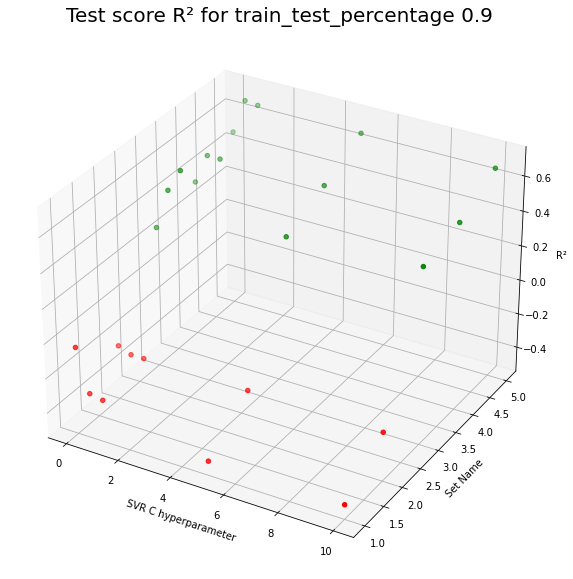

In [43]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

colour= np.where(z < 0, "r", "g")
scatter = ax.scatter(x, w, z, c=colour, marker='o')

ax.set_xlabel('SVR C hyperparameter')
ax.set_ylabel('Set Name')
ax.set_zlabel('R\u00b2')
ax.set_title(" ".join(["Test score R\u00b2 for train_test_percentage", str(train_test_percentages[0])]), fontsize=20)
plt.show()

### Forecast Dataset

In [44]:
# Best model
X_train, X_test, y_train, y_test, meanX_array, stdX_array, meany_array, stdy_array = process(data, target=target, features=sets_to_test["set5"],
                                           train_test_percentage=1)
model = LinearSVR(C=0.5, epsilon=0, max_iter=100000)
model.fit(X_train, y_train)
print(colored("\nSVR Model weights", "red", attrs=["blink"]))
[print(colored(i[0]+": ", "green", attrs=["blink"]), i[1].round(4)) for i in zip(sets_to_test["set5"], list(model.coef_))];

normalisedXtrain_array.shape=(181, 7), normalisedXtest_array.shape=(0, 7), normalisedytrain_array.shape=(181, 1), normalisedytest_array.shape=(0, 1)

SVR Model weights
electricity_consumption_statista_eia_Gigawatt/h:  0.542
oal_close_price_refiniti_CO-FOBNWC-AU:  0.4469
energy_mix_eia_Fossil fuels (billion kWh):  -0.0552
energy_mix_eia_Solar (billion kWh):  0.4849
energy_mix_eia_Hydroelectricity (billion kWh):  0.1251
energy_mix_eia_Wind (billion kWh):  -0.4079
energy_mix_eia_Biomass and waste (billion kWh):  -0.3115


/Users/macbookpro/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [45]:
forecast_files = ["consumption_forecast_eia.csv", "aucoalprice_forecast_kpmg.csv", "energymix_forecast_icis.csv"]

In [46]:
DF = pd.DataFrame()
for file in forecast_files:    
    a = pd.read_csv("forecast_data/" + file, index_col=0)
    a.index=pd.to_datetime(a.index)
    a = a.resample('M').last().reset_index().set_index('Date').interpolate(method='linear')
    a.index = pd.PeriodIndex(a.index, freq="M")
    DF = pd.concat([DF, a], axis=1)
    
cols = ["Consumption", "CoalPrice", "Fossils (Gas and Coal)", "Solar", "Hydroelectric", "Wind", "Biomass"]
DF = DF[cols]
DF

,Consumption,CoalPrice,Fossils (Gas and Coal),Solar,Hydroelectric,Wind,Biomass
Date,,,,,,,
2022-12,304.180000,85.100000,57.124378,17.498650,15.947566,6.451613,2.977793
2023-01,304.336667,84.658333,57.117074,17.498669,15.959049,6.434812,2.990396
2023-02,304.493333,84.216667,57.109770,17.498688,15.970532,6.418011,3.002999
2023-03,304.650000,83.775000,57.102466,17.498708,15.982015,6.401210,3.015602
2023-04,304.806667,83.333333,57.095163,17.498727,15.993497,6.384409,3.028205
...,...,...,...,...,...,...,...
2030-08,306.100000,66.546667,44.444444,22.777778,16.666667,11.358911,4.752200
2030-09,306.075000,66.435000,44.166667,22.916667,16.666667,11.435850,4.814150
2030-10,306.050000,66.323333,43.888889,23.055556,16.666667,11.512789,4.876100


### Predicted Electricity prices for 2022-2030

In [47]:
array_to_predict = DF.values
normalised_array = ((array_to_predict.T - meanX_array) / stdX_array).T
predicted = model.predict(normalised_array)

Text(0.5, 0, '')

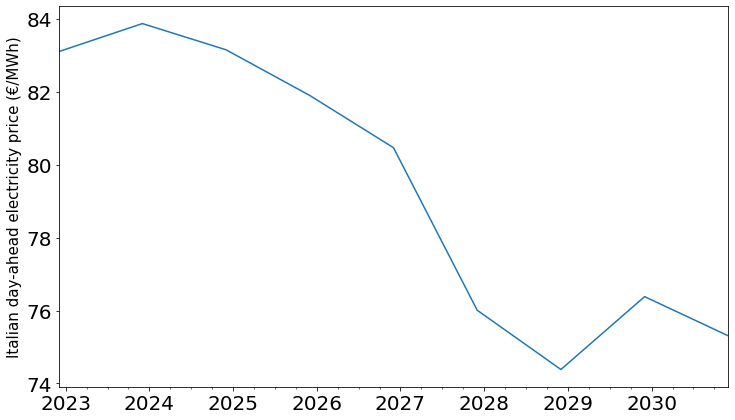

In [57]:
real_predictions = (predicted * stdy_array) + meany_array
pred_DF = pd.DataFrame(real_predictions.ravel(), index=DF.index)
pred_DF.plot(figsize=(12, 7), legend=False, fontsize=20)
plt.ylabel('Italian day-ahead electricity price (€/MWh)', fontsize=15)
plt.xlabel("", fontsize=15)